source: https://www.tensorflow.org/tutorials/generative/dcgan

숫자 데이터를 학습해서 가짜 숫자 데이터를 만들어 보자 

In [ ]:
import os 
from glob import glob 
import time

import imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from IPython import display 

%matplotlib inline

## HyperParameter

In [ ]:
batch_size = 256
num_epochs = 50
noise_dim = 100

num_examples_to_generate = 16

## Load Datset

In [ ]:
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()

train_images = train_images[..., tf.newaxis]
train_images = (train_images - 127.5) / 127.5  # [-1, 1]
train_images = train_images.astype(np.float32)

np.min(train_images), np.max(train_images)

(-1.0, 1.0)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(train_images)
dataset = dataset.shuffle(6000)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

# Build Models

In [ ]:
# Generator 
def build_generator():
    inputs = layers.Input((100,))
    net = layers.Dense(7*7*256, use_bias=False)(inputs)
    net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Reshape((7, 7, 256))(net)

    net = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='SAME', use_bias=False)(net)
    net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='SAME', use_bias=False)(net)
    net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='SAME', use_bias=False)(net)

    return tf.keras.Model(inputs=inputs, outputs=net, name='generator')

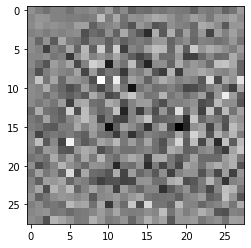

In [ ]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], 'gray')
plt.show()

In [ ]:
def build_discriminator():
    inputs = layers.Input([28, 28, 1])

    net = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='SAME')(inputs)
    net = layers.LeakyReLU()(net)
    net = layers.Dropout(0.3)(net)

    net = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='SAME')(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dropout(0.3)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(1)(net)

    return tf.keras.Model(inputs=inputs, outputs=net, name='discriminator')

In [ ]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00134278]], dtype=float32)>

## Optimization Setting

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

In [ ]:
# Checkpoint 저장 
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
  
    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
  
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

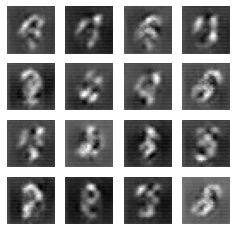

Time for epoch 1 is 1321.1127715110779 sec


In [ ]:
for epoch in range(num_epochs):
    start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, num_epochs, seed)